<a href="https://colab.research.google.com/github/malcolmfisher103/Bioinformatic-Scripts/blob/main/Tissue_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Xenbase tissue heatmaps

This Python script pulls GEO data from the [Xenbase](https://www.xenbase.org/xenbase/) model organism database and maps the existing row and column names into more human readable formats. The script also averages the TPM values across replicates for the same sample/conditions.

The original GEO/SRA data has been processed through Xenbase's [RNA-Seq pipeline](https://gitlab.com/Xenbase/bioinformatics/RNAseq-Pipeline/-/tree/main?ref_type=heads). [Forteide et al. (2020)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7145613/) describes the general process but the pipeline has since been updated.

This script takes a species and a set of genes to generate heatmaps for. The *X. laevis* data is sourced from '[GSE73419](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE73419)' and the *X. tropicalis* data is sourced from '[GSE43520](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE43520)'. These provide slightly different tissue datasets for the different species. Two heatmaps are generated, one with normalization across samples and the other with Log2 transformation.

In [ ]:
# @title Set GSE

Species = "X. tropicalis" # @param ["X. laevis", "X. tropicalis"]
if Species == "X. laevis" :
     GSE_ID = "GSE73419"
     Genome_build = "XENLA_10.1"
else:
    GSE_ID = "GSE43520"
    Genome_build = "XENTR_10.0"
selected_genes = ['PAX8','tbxt','shh','COX1','plink'] # @param {type:"raw"}

In [ ]:
# @title Load Modules
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Add this line
from matplotlib.ticker import LogLocator
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# @title Load Data
def load_tpm_matrix():
    return pd.read_csv(f'https://bigfrog.xenbase.org/xenbase/genomics/GEO/{GSE_ID}/{Genome_build}/RNA-Seq/ExpressionFiles/Genes_TPM_Matrix.txt', sep='\t', index_col=0)

def load_gene_info():
    return pd.read_csv('https://xenbase-bio1.ucalgary.ca/cgi-bin/reports/models_gene_info.cgi', sep='\t', index_col=0)

def load_gsm_sample_mapping():
    return pd.read_csv(f'https://bigfrog.xenbase.org/xenbase/genomics/GEO/{GSE_ID}/{Genome_build}/RNA-Seq/gsm_to_track.txt', sep='\t')

def load_gsm_srr_mapping():
    return pd.read_csv('https://download.xenbase.org/xenbase/GenePageReports/geo_srr_metadata_chd.txt', sep='\t')

def load_gse_species_mapping():
    return pd.read_csv('https://download.xenbase.org/xenbase/GenePageReports/geo_metadat_chd.txt', sep='\t')

def create_gsm_to_srr_mapping(gsm_srr_mapping):
    return gsm_srr_mapping[['SRR', 'GSM']]

In [ ]:
# @title Substitute Gene Symbols in Matrix
def substitute_gene_symbols(tpm_matrix, gene_info):

# Drop rows with null values in column 1 and column 2 in file 2
  gene_info = gene_info.dropna(subset=['GENE_SYMBOL', 'MODEL_NAME'])

# Drop duplicates in file 2 based on column 2
  gene_info = gene_info.drop_duplicates(subset=['MODEL_NAME'])

# Create a mapping dictionary from column 2 to column 1 in file 2
  mapping = dict(zip(gene_info['MODEL_NAME'], gene_info['GENE_SYMBOL']))

# Replace values in column 1 of file 1 with corresponding values from file 2
  tpm_matrix['Gene'] = tpm_matrix['Gene'].map(mapping).fillna(tpm_matrix['Gene'])

# Save the modified DataFrame back to file1.csv or use it as needed
  return tpm_matrix

In [ ]:
# @title Human Readable TPM matrix Generation
def process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping):
    # Substituting gene symbols
    tpm_matrix = substitute_gene_symbols(tpm_matrix, gene_info) #This works

    # Mapping GSMs to SRRs
    gsm_to_srr = create_gsm_to_srr_mapping(gsm_srr_mapping)

    # Select columns 2 and 6 to create a DataFrame with Track Name and GSMs
    gsm_mapping = gsm_sample_mapping[['Track Name', 'GSMs']]

    # Convert GSMs column to list if it contains comma-separated values
    gsm_mapping.loc[:, 'GSMs'] = gsm_mapping['GSMs'].str.split(',')

    # Explode the list of GSMs to create multiple rows for each track name
    gsm_mapping = gsm_mapping.explode('GSMs')
    # Merge gsm_mapping with gsm_srr_mapping on the 'GSM' column to get corresponding SRRs
    track_srr_mapping = pd.merge(left=gsm_mapping, right=gsm_srr_mapping, left_on='GSMs', right_on='GSM', validate="1:m")
    # Group by 'Track Name' and aggregate the corresponding SRRs into lists
    track_srr_mapping = track_srr_mapping.groupby('Track Name')['SRR'].apply(list).reset_index()
    track_srr_mapping_expanded = track_srr_mapping.explode('SRR')
    #print(track_srr_mapping_expanded.head(10))

    srr_columns = tpm_matrix.columns.intersection(track_srr_mapping_expanded['SRR'])
    #print(srr_columns)
    srr_to_track = dict(zip(track_srr_mapping_expanded['SRR'], track_srr_mapping_expanded['Track Name']))

    # Grouping TPM matrix by SRRs
    tpm_matrix.rename(columns={col: srr_to_track.get(col, col) for col in srr_columns}, inplace=True)
    #print(tpm_matrix.head(10))

    # Melt the DataFrame to have a single column for the gene and the rest for values
    tpm_matrix = pd.melt(tpm_matrix, id_vars=['Gene'], var_name='Column')

    # Extract the unique column names excluding the first column (Gene)
    columns_to_merge = tpm_matrix['Column'].unique()[1:]

    # Group by track names and take the mean
    tpm_matrix_grouped = tpm_matrix.groupby(['Gene', 'Column']).mean().unstack()

    # Display the first 10 rows and first 5 columns
    # print(tpm_matrix_grouped.iloc[:10, :5])

    # Remove the hierarchical index and reset index
    tpm_matrix_grouped.columns = tpm_matrix_grouped.columns.droplevel()
    tpm_matrix_grouped.reset_index(inplace=True)

    #print(tpm_matrix_grouped.head(10))

    return tpm_matrix_grouped

In [ ]:
# @title Main Script
def main():

    # Load data
    tpm_matrix = load_tpm_matrix()
    tpm_matrix = tpm_matrix.reset_index()
    gsm_srr_mapping = load_gsm_srr_mapping()
    gene_info = load_gene_info()
    gene_info = gene_info.reset_index()
    gsm_sample_mapping = load_gsm_sample_mapping()

    # Process data
    new_tpm_matrix = process_data(tpm_matrix, gene_info, gsm_sample_mapping, gsm_srr_mapping)

    # Output new_tpm_matrix to file
    new_tpm_matrix.to_csv(f'{GSE_ID}_TPM.tsv', sep='\t')

if __name__ == "__main__":
    main()

The following genes are not present in the data: ['plink']


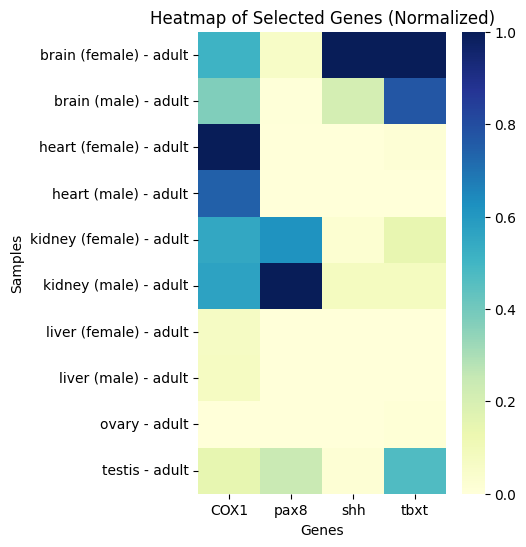

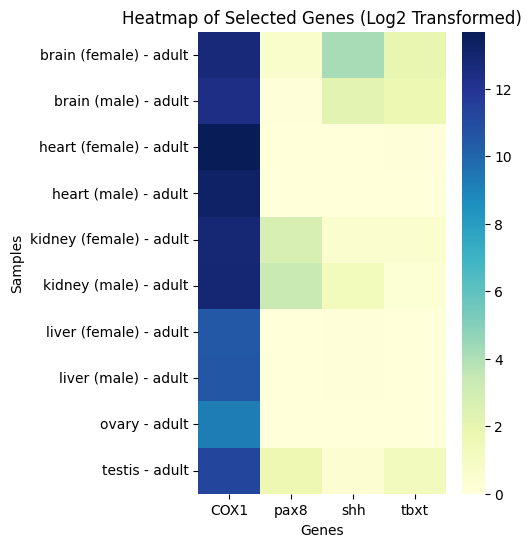

In [ ]:
# @title Swappable Heatmaps
# Read the data from the input file
df = pd.read_csv(f'{GSE_ID}_TPM.tsv', sep='\t', index_col=0)

# Set 'Gene' column as index
df.set_index('Gene', inplace=True)

# Choose specific genes (convert to lowercase)
selected_genes_lower = [gene.lower() for gene in selected_genes]

# Additional matching criteria for genes with suffix '.L' or '.S' (only for X. laevis)
if Species == "X. laevis":
    selected_genes_lower.extend([gene.lower() + suffix for gene in selected_genes for suffix in ['.l', '.s']])

# Filter out the selected genes that are present in the DataFrame
existing_genes_lower = [gene.lower() for gene in df.index]
existing_genes = [gene for gene in existing_genes_lower if gene in selected_genes_lower]

# Check if any selected genes are not present in the DataFrame
missing_genes_lower = [gene for gene in selected_genes_lower if gene not in existing_genes_lower]

# Strip suffixes from existing genes to check for missing genes
existing_genes_stripped = [gene.split('.')[0] if gene.endswith(('.l', '.s')) else gene for gene in existing_genes_lower]
missing_genes_stripped = [gene.split('.')[0] if gene.endswith(('.l', '.s')) else gene for gene in missing_genes_lower]
missing_genes = list(set([gene for gene in missing_genes_stripped if gene not in existing_genes_stripped]))

# If there are missing genes, print them
if missing_genes:
    print("The following genes are not present in the data:", missing_genes)

# Create a subset DataFrame containing only the existing genes
subset_df = df.loc[df.index.str.lower().isin(existing_genes)]

# Transpose the DataFrame
transposed_df = subset_df.transpose()

# Apply min-max scaling to normalize the expression values
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(transposed_df)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=transposed_df.columns, index=transposed_df.index)

# Determine the appropriate figsize based on the number of genes
num_genes = len(existing_genes)
figsize = (min(num_genes, 15), 6)  # Limit maximum figsize to 15 to avoid overly wide heatmaps

# Create the heatmap for normalized data
plt.figure(figsize=figsize)
sns.heatmap(normalized_df, cmap="YlGnBu")
plt.title('Heatmap of Selected Genes (Normalized)')
plt.xlabel('Genes')
plt.ylabel('Samples')
plt.show()

# Apply log2 transform to the expression values
log2_transformed_data = np.log2(transposed_df + 1)  # Adding 1 to avoid log(0)

# Create the heatmap for log2 transformed data
plt.figure(figsize=figsize)
sns.heatmap(log2_transformed_data, cmap="YlGnBu")
plt.title('Heatmap of Selected Genes (Log2 Transformed)')
plt.xlabel('Genes')
plt.ylabel('Samples')
plt.show()
